# Demo1 

In [1]:
%matplotlib inline
import gc
import time
import fpfs

import numpy as np
import matplotlib.pyplot as plt
import numpy.lib.recfunctions as rfn

## image simulation
+ fpfs.simutil.sim_test is the test to simulation simple galaxy image and test shear estimation

SNR is 26.06


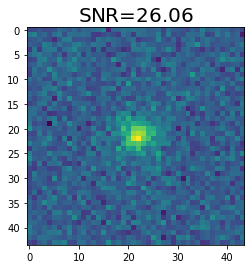

In [2]:
rng     =   np.random.RandomState(212)
testTask=   fpfs.simutil.sim_test(shear=[0,0],rng=rng)
ngrid   =   testTask.img.shape[0]
flux_gal=   np.sum(testTask.img[ngrid//2-2:ngrid//2+3,ngrid//2-2:ngrid//2+3])
noi_std =   3e-3
print('SNR is %.2f' %(flux_gal/(noi_std*5)))
sims= testTask.make_image(noise=noi_std,psf_noise=0.)
gal = sims[0]
psf = sims[1]
plt.close()
plt.imshow(gal)
_=plt.title(r'SNR=$%.2f$'%(flux_gal/(noi_std*5)),fontsize=20)

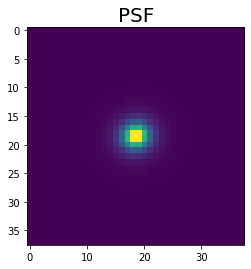

In [3]:
plt.close()
plt.imshow(psf)
_=plt.title('PSF',fontsize=20)

## shear estimation
+ fpfs.fpfsBase.fpfsTask is the task to measure shear from galaxies

In [4]:
def analyze_FPFS(rng:np.random.RandomState, input_shear:np.ndarray, num_gals:int,\
        noi_stds, noi_psf=0.):
    noi_stds=   np.array(noi_stds)
    if len(noi_stds.shape)==0:
        noi_stds=np.array([noi_stds])
    elif len(noi_stds.shape)>=2:
        raise ValueError('The input noi_stds should be float or 1d list')
    x     = []      # SNR
    y     = []      # estimated shear
    y_err = []      # error on shear
    # I am calling this task to simulate galaxy images:
    # https://github.com/mr-superonion/FPFS/blob/188ba8679b4db401129e7504ea5126143bafdee4/fpfs/simutil.py#L163
    testTask=   fpfs.simutil.sim_test(shear=input_shear,rng=rng)
    # get an aperture flux for SNR estimation
    ngrid   =   testTask.img.shape[0]
    flux_gal=   np.sum(testTask.img[ngrid//2-2:ngrid//2+3,ngrid//2-2:ngrid//2+3])
    # cutout PSF
    ngrid   =   testTask.psf.shape[0]
    rcut    =   16
    beg     =   ngrid//2-rcut
    end     =   beg+2*rcut
    # cutout PSF into postage stamp with width=2rcut
    psf     =   testTask.psf[beg:end,beg:end]
    gc.collect()
    num_tests=  noi_stds.size
    for i in range(num_tests):
        noii    =   noi_stds[i]
        x.append(flux_gal/(noii*5))
        # initialize FPFS task with an average psf and noise variance (or power spectrum)
        # beta<1 is the FPFS scale parameter
        fpTask  =   fpfs.fpfsBase.fpfsTask(psf,noiFit=noii**2.,beta=0.75)
        start= time.time()
        results =   []
        for _ in range(num_gals):
            # simulate one galaxy
            gal = testTask.make_image(noise=noii,psf_noise=noi_psf)[0]
            # cut out galaxy into 32x32 grids
            ngrid = gal.shape[0]
            beg = ngrid//2-rcut
            end = beg+2*rcut
            gal = gal[beg:end,beg:end]
            # FPFS measurement
            modes = fpTask.measure(gal)
            # append measured modes to the results list
            results.append(modes)
            del gal,modes,beg,end,ngrid
        end = time.time()
        print('%.5f seconds to process %d galaxies' %(end-start,num_gals))
        mms = rfn.stack_arrays(results,usemask=False)
        # set C = std(\delta M_00) * 5.
        C = np.sqrt(np.average(mms['fpfs_N00N00']))*5.
        ells = fpfs.fpfsBase.fpfsM2E(mms,const=C,noirev=False)
        del mms,results
        resp=np.average(ells['fpfs_RE'])
        shear=np.average(ells['fpfs_e1'])/resp
        shear_err=np.std(ells['fpfs_e1'])/np.abs(resp)/np.sqrt(num_gals)
        y.append(shear)
        y_err.append(shear_err)
    return np.array(x),np.array(y), np.array(y_err)

In [5]:
noi_stds = np.logspace(-4, -2, 5, base=10.0)
num_gals = 10000
snr, g1, g1err = analyze_FPFS(rng, np.array([0.03, 0.03]), num_gals, noi_stds)

1.79200 seconds to process 10000 galaxies
1.21826 seconds to process 10000 galaxies
1.21247 seconds to process 10000 galaxies
1.19499 seconds to process 10000 galaxies
1.13674 seconds to process 10000 galaxies


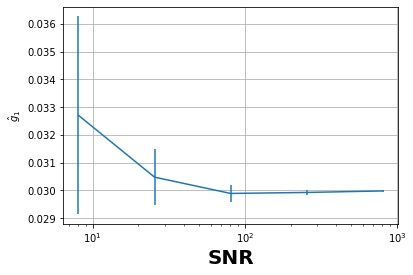

In [6]:
plt.close()
plt.errorbar(snr, g1, g1err)
plt.xlabel('SNR', fontsize=20,weight='bold')
plt.ylabel(r'$\hat{g}_1$')
plt.grid()
plt.xscale('log')